'''
[ENGLISH] INSTRUCTIONS FOR USING THIS TEMPLATE:
1. You are not allowed to change or remove existing templates; you are only permitted to add a few lines of code as per the given instructions and any necessary additions.
2. You may add or import any libraries deemed necessary to complete this assignment, within the limitations outlined in this course's laboratory guidelines.
GOOD LUCK! 😊💖



[INDONESIA] PETUNJUK PENGGUNAAN TEMPLATE INI:
1. Anda tidak diizinkan untuk mengubah atau menghapus template yang sudah ada; hanya diperbolehkan menambahkan beberapa baris kode sesuai dengan petunjuk yang diberikan dan tambahan yang bila diperlukan.
2. Anda diizinkan untuk menambahkan atau mengimpor library yang dianggap perlu selama proses pengerjaan tugas ini, namun terbatas pada ketentuan yang diberlakukan dalam praktikum mata kuliah ini.
SELAMAT MENGERJAKAN! 😊💖
'''

In [7]:
import os
import tensorflow as tf
import numpy as np
import random

In [8]:
PATH = 'dataset/'
dataset = []

for image_name in os.listdir(PATH):
    image_path = PATH + image_name
    image_data = tf.keras.utils.load_img(image_path, color_mode='rgb')
    image_data = np.array(image_data)
    dataset.append(image_data)

In [9]:
random.shuffle(dataset)
dataset = np.array(dataset)

IMAGE_SIZE = 32

"""
TODO:
You are tasked with reshaping the given dataset, which includes the training and testing sets, by converting the data type to float32. Following this, you will need to normalize the dataset, comprising the training and testing sets, by dividing the values of all image pixels by 255. 
"""


In [10]:
dataset = tf.random.shuffle(dataset, seed=19)
dataset = np.array(dataset)
dataset = dataset.astype('float32') / 255.0

"""
TODO:
You are tasked to split the given dataset into 2 main parts which are training and testing sets with the proportion of 60/40.
"""


In [11]:
train_size = int(len(dataset) * 0.60)
train_data = dataset[:train_size]
test_data = dataset[train_size:]

hidden_dim = 512
learning_rate = 0.00015
latent_dim = 32
epochs = 3
batch_size = 128

"""
TODO: 
Convolutional Variational Autoencoders Architecture (Model Architecture Visualization, Initialization, and Configuration)

Model Initialization and Configuration – Encoder
- Input Layer: This takes the data (like an image) as input.
- Hidden Layers: One or more layers that transform the input data. These can be fully connected layers, convolutional layers, or any other type of layer suitable for the data type.
- Output Layer: Produces two vectors for each input data point: a mean vector (μ) and a log variance vector (log⁡(σ^2)).
These vectors are used to parameterize the Gaussian distribution from which we’ll sample the latent variable ‘z’.

Model Initialization and Configuration – Decoder
This is a lower-dimensional space where we encode our data. A point ‘z’ in this space is sampled from the Gaussian distribution parameterized by μ and log⁡(σ^2 ) from the encoder. The reparameterization trick is used here to make this sampling process differentiable. Instead of directly sampling from the distribution, we sample from a standard normal distribution and then scale and shift using µ and σ. The formula for the reparameterization trick is z=μ+σ⊙ϵ, where μ is the mean vector produced by the encoder, σ is the standard deviation, and ϵ is a random noise sampled from a standard normal distribution. 

Model Initialization and Configuration – Decoder
- Input Layer: Takes the sampled ‘z’ from the latent space.
- Hidden Layers: One or more layers that transform the latent variable back towards the original data’s dimensionality.
- Output Layer: Produces the reconstructed data, ideally as close to the original input data as possible.
"""

In [12]:
class CVAE(tf.keras.Model):
    def __init__(self, dim, **kwargs):
        h_dim = dim[0]
        z_dim = dim[1]
        super(CVAE, self).__init__(**kwargs)
        self._name = "Convolutional Variational Autoencoder"

        # Encoder
        self.conv = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', strides=(2, 2), padding='same')
        self.conv._name = "encoder_Conv2D"
        self.pool = tf.keras.layers.MaxPool2D((2, 2), padding='same')
        self.pool._name = "encoder_MaxPool2D"
        self.conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', strides=(2, 2), padding='same')
        self.conv2._name = "encoder_Conv2D"
        self.flatten = tf.keras.layers.Flatten()
        self.flatten._name = "encoder_Flatten"
        self.fc1 = tf.keras.layers.Dense(h_dim)
        self.fc1._name = "encoder_fc"
        self.fc2_mu = tf.keras.layers.Dense(z_dim)
        self.fc2_mu._name = "encoder_fc_mu"
        self.fc2_log_var = tf.keras.layers.Dense(z_dim)
        self.fc2_log_var._name = "encoder_fc_log_var"

        # Decoder
        self.fc3 = tf.keras.layers.Dense(h_dim, activation='relu')
        self.fc3._name = "decoder_fc"
        self.fc4 = tf.keras.layers.Dense(16 * 16 * 32, activation='relu')
        self.fc4._name = "decoder_fc"
        self.reshape = tf.keras.layers.Reshape((16, 16, 32))
        self.reshape._name = "decoder_Reshape"
        self.deconv = tf.keras.layers.Conv2DTranspose(z_dim, kernel_size=(1, 1))
        self.deconv._name = "decoder_Conv2DTranspose"
        self.deconv2 = tf.keras.layers.Conv2DTranspose(z_dim, kernel_size=(1, 1))
        self.deconv2._name = "decoder_Conv2DTranspose"
        self.deconv3 = tf.keras.layers.Conv2DTranspose(3, kernel_size=(3, 3), strides=(2,2), padding='same')
        self.deconv3._name = "decoder_Conv2DTranspose"


    def encode(self, x):
        x = self.conv(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.flatten(x)
        h = tf.nn.relu(self.fc1(x))
        return self.fc2_mu(h), self.fc2_log_var(h)

    def reparameterize(self, mu, log_var):
        std = tf.exp(log_var * 0.5)
        eps = tf.random.normal(std.shape)
        return mu + eps * std

    def decode_logits(self, z):
        z = self.fc3(z)
        z = self.fc4(z)
        z = self.reshape(z)
        z = self.deconv(z)
        z = self.deconv2(z)
        return self.deconv3(z)
    
    def decode(self, z):
        return tf.nn.sigmoid(self.decode_logits(z))

    def call(self, inputs, training=None, mask=None):
        mu, log_var = self.encode(inputs)
        z = self.reparameterize(mu, log_var)
        x_reconstructed_logits = self.decode_logits(z)
        return x_reconstructed_logits, mu, log_var


model = CVAE([hidden_dim, latent_dim])
X_train = train_data.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 3))
X_test = test_data.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 3))

model.build(input_shape=(batch_size, IMAGE_SIZE, IMAGE_SIZE, 3))
print(model.summary())

Model: "Convolutional Variational Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_Conv2D (Conv2D)     multiple                  896       
                                                                 
 encoder_MaxPool2D (MaxPooli  multiple                 0         
 ng2D)                                                           
                                                                 
 encoder_Conv2D (Conv2D)     multiple                  18496     
                                                                 
 encoder_Flatten (Flatten)   multiple                  0         
                                                                 
 encoder_fc (Dense)          multiple                  524800    
                                                                 
 encoder_fc_mu (Dense)       multiple                  16416     
                             

"""
TODO:
You are tasked with training the model that you previously constructed. Utilize the Adam optimizer and select the appropriate loss function based on the specifics of your case. Monitor the performance using reconstruction loss and KL Divergence as the metric. Ensure that the training process spans a minimum of 1000 epochs. You have the flexibility to set the batch size and learning rate for the optimizer according to your judgment. Furthermore, you are free to determine the appropriate hidden dimension and latent dimension sizes for your model’s architecture.
"""

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate)

dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(batch_size * 5).batch(batch_size)
num_batches = X_train.shape[0] // batch_size

loss_list = []
kldiv_list = []

for epoch in range(epochs):
    for step, x in enumerate(dataset):
        x = tf.reshape(x, [-1, IMAGE_SIZE, IMAGE_SIZE, 3])
        with tf.GradientTape() as tape:
            x_reconstruction_logits, mu, log_var = model(x)

            reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_reconstruction_logits)
            reconstruction_loss = tf.reduce_sum(reconstruction_loss) / batch_size
            kl_div = - 0.5 * tf.reduce_sum(1. + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
            kl_div = tf.reduce_mean(kl_div)

            loss = tf.reduce_mean(reconstruction_loss) + kl_div

        gradients = tape.gradient(loss, model.trainable_variables)
        for g in gradients:
            tf.clip_by_norm(g, 15)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if (step + 1) % 5 == 0:
            loss_list.append(reconstruction_loss)
            kldiv_list.append(kl_div)
            print(
                f"Epoch[{epoch + 1}/{epochs}], Step[{step + 1}/{num_batches}], Reconstruction Loss: {float(reconstruction_loss):.2f}, KL Div: {float(kl_div):.2f}")


Epoch[1/3], Step[5/23], Reconstruction Loss: 2125.76, KL Div: 0.04
Epoch[1/3], Step[10/23], Reconstruction Loss: 2120.28, KL Div: 0.09
Epoch[1/3], Step[15/23], Reconstruction Loss: 2116.43, KL Div: 0.27
Epoch[1/3], Step[20/23], Reconstruction Loss: 2105.81, KL Div: 0.77
Epoch[2/3], Step[5/23], Reconstruction Loss: 2095.07, KL Div: 1.90
Epoch[2/3], Step[10/23], Reconstruction Loss: 2082.28, KL Div: 2.95
Epoch[2/3], Step[15/23], Reconstruction Loss: 2083.18, KL Div: 3.75
Epoch[2/3], Step[20/23], Reconstruction Loss: 2064.24, KL Div: 3.27
Epoch[3/3], Step[5/23], Reconstruction Loss: 2051.89, KL Div: 3.61
Epoch[3/3], Step[10/23], Reconstruction Loss: 2048.36, KL Div: 5.19
Epoch[3/3], Step[15/23], Reconstruction Loss: 2046.94, KL Div: 7.02
Epoch[3/3], Step[20/23], Reconstruction Loss: 2051.86, KL Div: 7.87


"""
TODO:
You are tasked with evaluating the testing sets using the model that you previously constructed. Display both the original and the reconstructed images, showcasing 10 images each.
"""

(2000, 32)
<class '__main__.CVAE'>


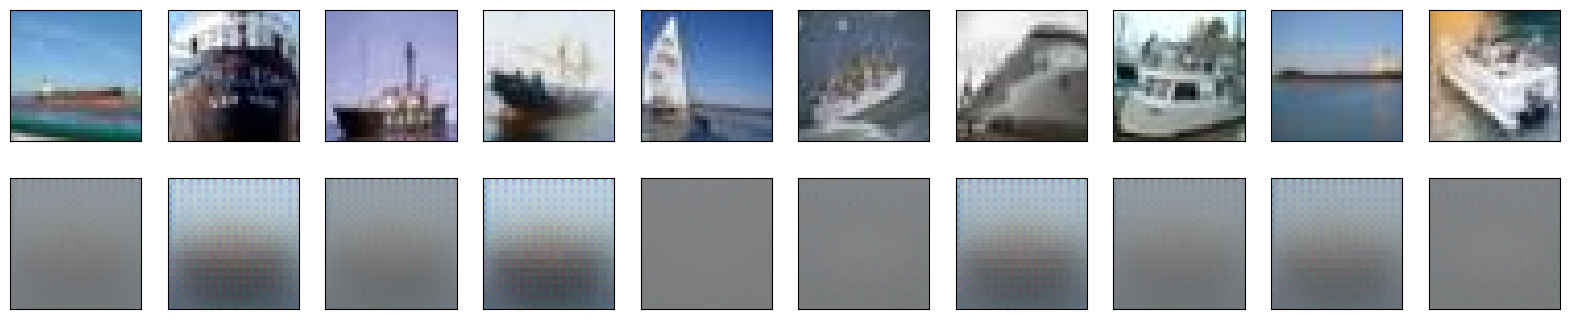

In [14]:
import matplotlib.pyplot as plt

mu, log_var = model.encode(X_test)
print(np.array(mu).shape)
out = model.decode(mu)

print(type(model))
out = tf.reshape(out, [-1, IMAGE_SIZE, IMAGE_SIZE, 3]).numpy() * 255
out = out.astype(np.uint8)

number = 10

plt.figure(figsize=(20, 4))
for i in range(number):
    ax = plt.subplot(2, number, i+1)
    plt.xlabel("Rec")
    plt.imshow(X_test[i+20], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
for i in range(number):
    ax = plt.subplot(2, number, i + 11)
    plt.imshow(out[i+20], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()